In [43]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.pyplot import figure, show, close, xlabel, ylabel, title
from scipy.constants import k, h, c,e
from scipy.optimize import curve_fit
from spectrapepper import alsbaseline

In [44]:
def f_gaussian(x, amp, mu, sigma, zero):
    """returns the value of a Gaussian function with amplitude amp centered at position mu with width sigma and 
    offset with respect to the x-axis off zero"""
    # amp, mu, sigma, zero = p
    return amp * np.exp(-(x - mu) * (x - mu) / (2.0 * sigma * sigma)) + zero

def f_exp(x, a,b,z):
    """returns an exponential function of the form a*exp(b*x)"""
    return a*np.exp(b*x)+z

In [45]:
hdulist = fits.open('Reynier files/arcturus_wl.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(dat,color="navy", label="Vega spectrum")
frame.set_title("Arcturus: our data")
frame.grid(alpha=0.2)
show()
close(fig)

hdulist.close()

FileNotFoundError: [Errno 2] No such file or directory: 'Reynier files/arcturus_wl.fits'

In [ ]:
x_range = np.arange(1, dat.size+1)

# dat_smooth=alsbaseline(dat, remove=False)[200:]
dat_smooth=dat
x_range=x_range

# fitting the 1st peak
beta, pcov1 = curve_fit(f_gaussian, x_range[250:600], dat_smooth[250:600], p0=(-1, 450, 5, 1)) 
#amp, mu, sigma, zero

print(beta)

a1,m1,s1,z1=beta


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(f_gaussian(x_range,a1,m1,s1,z1),color="paleturquoise", label="fit for the 1st peak")
frame.set_title("Arcturus: 1st peak fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

NameError: name 'x_range' is not defined

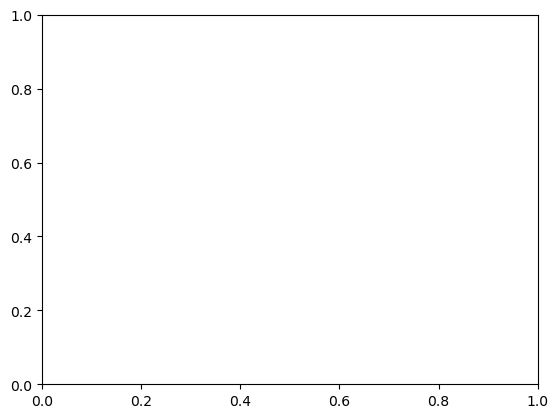

In [46]:

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(f_gaussian(x_range,a1,m1,s1,z1),color="paleturquoise", label="fit for the 1st peak")
frame.set_title("Arcturus: 1st peak fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [ ]:
# questionably short

#fitting the last peak
beta, pcov5 = curve_fit(f_gaussian, x_range, dat_smooth, p0=(-0.4, 1900, 50, 1.1))
a5,m5,s5,z5=beta
z = np.mean([z1,z5])

f_composed = f_gaussian(x_range,a1,m1,s1,z)+f_gaussian(x_range,a5,m5,s5,0)
fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(f_composed,color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [ ]:
def f_superb(x,a1,m1,s1, a5,m5,s5, a,b,z):
    """Returns a combination of 2 Gaussians plotted on an exponential"""
    gaussian1 = a1 * np.exp(-(x - m1) ** 2 / (2.0 * s1 ** 2))
    gaussian2 = a5 * np.exp(-(x - m5) ** 2 / (2.0 * s5 ** 2))
    exponential = a * np.exp(b * x) + z
    return gaussian1 + gaussian2 + exponential

beta, pcov_exp = curve_fit(f_exp,x_range,dat_smooth,p0=(1,0.0001,1))
print(beta)
exp_a,exp_b,exp_z = beta

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(x_range,f_exp(x_range,exp_a,exp_b,exp_z),color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: exponential fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)



In [ ]:
D1=np.array([a1,m1,s1])
D5=np.array([a5,m5,s5])
D_exp=np.array([exp_a,exp_b,1])

# fitting again to the superb function

beta,pcov =curve_fit(f_superb, x_range, dat_smooth, p0=np.concatenate([D1, D5, D_exp]))
np.concatenate([D1, D5, D_exp])
a1,m1,s1,a5,m5,s5,a,b,z=beta
print(beta)

#printing the final fit

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(x_range,f_superb(x_range,a1,m1,s1,a5,m5,s5,exp_a,exp_b,exp_z),color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: 2 peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [ ]:
# a function for multiple exponentials

def f_superior(x, *params):
    """Returns a combination of multiple Gaussians plotted on an exponential"""
    num_gaussians = (len(params) - 3) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    # exponential part
    exp_a, exp_b, exp_z = params[-3:]
    y += exp_a * np.exp(exp_b * x) + exp_z
    return y

initial_gaussians = [D1, D5] # more will be added as needed
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [exp_a, exp_b, exp_z] # flattening the initial guesses for curve_fit

beta, pcov = curve_fit(f_superior, x_range, dat_smooth, p0=initial_guess)

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
exp_params = beta[num_gaussians * 3:]
print("Gaussian parameters:", gaussian_params)
print("Exponential parameters:", exp_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range, dat_smooth, color="royalblue", label="Arcturus spectrum", s=1)
frame.plot(x_range, f_superior(x_range, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [ ]:
D2=np.array([-0.1,1050,5])
D3 = np.array([-0.1,1350,20])
D4 = np.array([-0.15,1600,10])

initial_gaussians = [D1,D2,D3,D4, D5]
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [exp_a, exp_b, exp_z]

beta, pcov = curve_fit(f_superior, x_range, dat_smooth, p0=initial_guess)
print("Parameters:", beta) #it's not printing the figure if i remove this line, no idea why

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
exp_params = beta[num_gaussians * 3:]

# poor attempt at error analysis
# gaussian_params_err = pcov[:num_gaussians * 3].reshape((num_gaussians, 3))
# exp_params_err = pcov[num_gaussians * 3:]
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
print("Exponential parameters:", exp_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range, dat_smooth, color="royalblue", label="Arcturus spectrum", s=1)
frame.plot(x_range, f_superior(x_range, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

In [ ]:
# for Peak in gaussian_params:
#     fwhm,fwhm_err=fwhm_calculator(Peak[2],pcov)
#     fwhm=2*sigma*np.sqrt(2*np.log(2))
    
FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

c=0
for Peak in gaussian_params:
    print(f"Peak {c} equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

x_range_a = 1.217*x_range + 7060

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,dat_smooth, color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(x_range_a,f_superior(x_range, *beta),color="paleturquoise", label="fit for the 1st peak")

p=0
for Peak in gaussian_params:
    a,m,s=Peak
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))
    
    # getting the exponential fit data to know the y-coordinates of FWHM plot
    exp_a,exp_b,exp_z=exp_params
    z=f_exp(m,exp_a,exp_b,exp_z)    
    
    fwhm_y=np.array((a/2+z,a/2+z))
    
    frame.plot(1.217*fwhm_x + 7060,fwhm_y,color="green", label=f"FWHM for peak {p}")
    p+=1
    
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)


In [ ]:
# getting the MILES ccomparison spectrum for Arcturus

hdulist = fits.open('miles spectra/arcturus_miles.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")
arcturus_miles = dat[0,:]

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(arcturus_miles,color="navy", label="Vega spectrum")
frame.set_title("Arcturus-like (K1.3) star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)